# LiveEO Data Science Challenge - Thibault Latrace

![Sentinel-2 satellite](resources/sentinel-2_image.jpg)

This notebook aims at solving the LiveEO Sentinel-2 challenge, whose wording can be found in the GitHub repository.

The goal is to implement a machine learning model able to predict the type of a geographic area (forest, water, urban...) from Sentinel-2 satellite image scenes. The Sentinel-2 (S-2) satellite is equipped with a Multi-Spectral Instrument (MSI) which can provide up to 15 spectral bands ranging from the visible range to the shortwave infrared, plus additional band outputs. These bands will be our features in this study.

My **problem solving stategy** is the following : 

- Dataset exploration
- Classifier training
- Model accuracy evalutation & limits

Let's dive into it !

## I. Dataset exploration

Import of the libraries and the tools that will be used during the whole study :

In [1]:
import rasterio
import matplotlib.pyplot as plt
import folium
import numpy as np
import pandas as pd
import os
import scikitplot as skplt

from pyproj import Transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline

Exploration of the labeled dataset metadata :

In [2]:
dataset = rasterio.open('resources/rasterize_on_sentinel_2_labelled_17SLD.tif')

print('Dataset metadata : \n\n'+ str(dataset.meta))

print('\n\nCRS : ' + str(dataset.meta['crs']))
print('Shape : ' + str(dataset.shape))
print('Number of bands : ' + str(dataset.count))
print('Type of the first layer : ' + str(list(dataset.dtypes)[0]))
print('Nodata value : ' + str(dataset.nodata))

Dataset metadata : 

{'driver': 'GTiff', 'dtype': 'uint32', 'nodata': 4294967295.0, 'width': 10980, 'height': 10980, 'count': 2, 'crs': CRS.from_epsg(32617), 'transform': Affine(10.0, 0.0, 300000.0,
       0.0, -10.0, 4400040.0)}


CRS : EPSG:32617
Shape : (10980, 10980)
Number of bands : 2
Type of the first layer : uint32
Nodata value : 4294967295.0


Thus, the Coordinates Reference System is EPSG:32617, which corresponds to the **UTM zone 17N** according to the documentation of the [epsg.io website](https://epsg.io/32617).

In order to have a precise overview of the problem, we should see on a map what zone of the world is on the picture. Let's see what area this picture delimits :

In [3]:
# use of the metada affine transformation matrix to spot the spatial position of the four picture corners in the crs 32617
previous_upper_left_corner_coords = dataset.transform * (0, 0)
previous_upper_right_corner_coords = dataset.transform * (dataset.width, 0)
previous_lower_left_corner_coords = dataset.transform * (0, dataset.height)
previous_lower_right_corner_coords = dataset.transform * (dataset.width, dataset.height)

# transformer implementation to switch the crs to the classic WGS 84 CRS
utm_zone_17N_crs = 32617
WGS84_crs = 4326
transformer = Transformer.from_crs(utm_zone_17N_crs, WGS84_crs)

# corners coordinates conversion
corners = [
    previous_upper_left_corner_coords,
    previous_upper_right_corner_coords,
    previous_lower_left_corner_coords,
    previous_lower_right_corner_coords
]
corners_coords = list()
for point in transformer.itransform(corners):
    coords = '{} {}'.format(*point)
    x = coords.split(' ')[0]
    y = coords.split(' ')[1]
    corners_coords.append((x, y))
new_upper_left_corner_coords = corners_coords[0]
new_upper_right_corner_coords = corners_coords[1]
new_lower_left_corner_coords = corners_coords[2]
new_lower_right_corner_coords = corners_coords[3]

Let's watch on an interactive map to what area corresponds the image :

In [4]:
# creation of a folium interactive map
m = folium.Map(list(new_lower_right_corner_coords),zoom_start = 6, tiles='Stamen Terrain')
folium.Marker(list(new_upper_left_corner_coords)).add_to(m)
folium.Marker(list(new_upper_right_corner_coords)).add_to(m)
folium.Marker(list(new_lower_left_corner_coords)).add_to(m)
folium.Marker(list(new_lower_right_corner_coords)).add_to(m)
m

*Our area is located in the square delimited by the four corner markers. It is next to **Columbus** (Ohio) in the United States.* It is consistent because this area is in the scope of UTM zone 17N.

Let's now visualize the dataset :

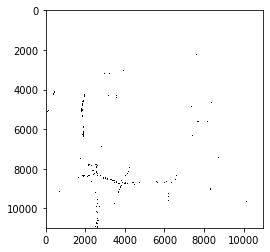

In [5]:
labeled_band = dataset.read(1)

plt.imshow(labeled_band, cmap='hot')

All the black dots are the labelled parts. We can see that the majority of the data are nodata values !

We now transform the labelled band into a DataFrame in order to ease the manipulation,by dropping the label nodata values : 

In [6]:
reduced_label_band_df = pd.DataFrame(labeled_band.ravel()).replace(4294967295, pd.NA)
previous_label_band_size = reduced_label_band_df.shape

# this is the key step where we drop nodata values
reduced_label_band_df = reduced_label_band_df.dropna().rename(columns = {0: 'label'})
new_label_band_size = reduced_label_band_df.shape

# forcing the label to int value
reduced_label_band_df['label'] = reduced_label_band_df['label'].astype(int)

print('Reduction coefficient :' + str(np.round(previous_label_band_size[0]/new_label_band_size[0])))

Reduction coefficient :369.0


We just **divided by almost 400 the size** of our dataset !!!
It will be a lot more convenient to work with this size-reduced data for the machine learning process

Concatenation of the labeled layer and the 15 bands of the dataset, by projecting the bands where the labeled data is not null : 

In [7]:
bands_folder_path = 'resources/S2_17SLD_2019-09-15_masked_warped'

# list of the paths of the 15 bands
band_paths = [os.path.join(bands_folder_path, my_file)
              for my_file in os.listdir(bands_folder_path)
              if os.path.isfile(os.path.join(bands_folder_path, my_file))]

bands_names = list()
for band_number in range(len(band_paths)):
    with rasterio.open(band_paths[band_number]) as band_dataset:
        band_name = '{}'.format(band_paths[band_number].split('\\')[1].split('_')[2])
        band_df = pd.DataFrame(band_dataset.read(1).ravel()).rename(columns = {0: band_name})
        bands_names.append(band_name)
        
        # concatenation of the band with the dataset
        reduced_label_band_df = pd.concat([reduced_label_band_df, band_df.reindex(reduced_label_band_df.index)], axis = 1)
        print(reduced_label_band_df)
        band_dataset.close()

# I reset the index and store the previous one : if necessary we could unravel it to translate it into (x, y) coordinates
final_dataset_df = reduced_label_band_df.reset_index().rename(columns = {'index': 'previous_index'})

           label  AOT
350913         3   69
354514         0   70
354515         0   70
354516         0   70
354517         0   70
...          ...  ...
120332403      4   70
120409747      3   70
120420734      3   70
120464649      3   70
120519538      3   70

[326391 rows x 2 columns]
           label  AOT   B01
350913         3   69   360
354514         0   70  2347
354515         0   70  2347
354516         0   70  3878
354517         0   70  3878
...          ...  ...   ...
120332403      4   70   264
120409747      3   70   589
120420734      3   70   760
120464649      3   70   768
120519538      3   70   442

[326391 rows x 3 columns]
           label  AOT   B01   B02
350913         3   69   360   391
354514         0   70  2347  2302
354515         0   70  2347  4328
354516         0   70  3878  4316
354517         0   70  3878  4460
...          ...  ...   ...   ...
120332403      4   70   264   236
120409747      3   70   589   322
120420734      3   70   760   713
120464

           label  AOT   B01   B02   B03   B04   B05   B06   B07   B08   B09  \
350913         3   69   360   391   640   735  1274  1954  2300  2374  2620   
354514         0   70  2347  2302  2674  2778  3944  4185  3975  2784  2979   
354515         0   70  2347  4328  4272  4220  3944  4185  3975  4220  2979   
354516         0   70  3878  4316  4564  4728  5445  5242  5489  4500  3836   
354517         0   70  3878  4460  4400  4792  5445  5242  5489  4600  3836   
...          ...  ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
120332403      4   70   264   236   466   263   702  2844  3513  3340  3834   
120409747      3   70   589   322   462   473  1077  1570  1836  1596  1835   
120420734      3   70   760   713   939   991  1288  1654  1832  1780  1812   
120464649      3   70   768   517   576   686  1084  1603  1857  2064  2022   
120519538      3   70   442   329   530   438   949  1697  1891  1992  1924   

            B11   B12   B8A  
350913     2853  1803

Let's now reindex and add of a label mapping in order to improve readibility of the dataset. I used the [European Space Agency documentation](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi/resolutions/spatial) to translate the titles of the TIF files provided into scientific features :

In [8]:
# translation of the columns title with a mapping dictionnary
bands_meaning = ['AOT',
                 'coastal_aerosol',
                 'blue',
                 'green',
                 'red',
                 'IR_705nm',
                 'IR_740nm',
                 'IR_783nm',
                 'IR_842nm',
                 'water_vapour',
                 'SWIR_1610nm',
                 'SWIR_2190nm',
                 'IR_865nm',
                 'SCL',
                 'WVP']
bands_meaning_mapping = {bands_names[i]: bands_meaning[i] for i in range(len(bands_names))}
final_dataset_df = final_dataset_df.rename(columns = bands_meaning_mapping)

#insertion of the label_meaning column
label_mapping = {0: 'urban', 1: 'treerow', 2: 'forest', 3: 'single tree', 4: 'agriculture', 5: 'grassland', 6: 'water'}
label_meaning_df = final_dataset_df['label'].replace(label_mapping)

pd.concat([final_dataset_df, label_meaning_df], axis = 1).head()

,previous_index,label,AOT,coastal_aerosol,blue,green,red,IR_705nm,IR_740nm,IR_783nm,IR_842nm,water_vapour,SWIR_1610nm,SWIR_2190nm,IR_865nm,SCL,WVP,label
0,350913,3,69,360,391,640,735,1274,1954,2300,2374,2620,2853,1803,2566,4,2728,single tree
1,354514,0,70,2347,2302,2674,2778,3944,4185,3975,2784,2979,3758,2708,3884,9,2241,urban
2,354515,0,70,2347,4328,4272,4220,3944,4185,3975,4220,2979,3758,2708,3884,9,2241,urban
3,354516,0,70,3878,4316,4564,4728,5445,5242,5489,4500,3836,4589,2917,5310,9,2518,urban
4,354517,0,70,3878,4460,4400,4792,5445,5242,5489,4600,3836,4589,2917,5310,9,2518,urban


Storing of the final dataset into a csv :

In [9]:
final_dataset_df.to_csv('final_dataset.csv',  index = False)

**CHECKPOINT** : To this point, we don't need to execute the code above anymore : the dataset is definitly stored in the file 'final_dataset.csv'. However, if we restart the kernel, we will still need to execute the first bloc of imports before continuing to execute the Model Training part.

## 2. Classifier Training

We split the dataset into train and test data : 80% for the training data and 20% for the testing one.

Furthermore, as long as we want to predict a class, we will use a Classifier model. It chose here to use a RandomForestClassifier.

In [10]:
final_dataset_df = pd.read_csv('final_dataset.csv')

# split of the dataset
prediction_target = final_dataset_df['label']
X1 = final_dataset_df.drop(columns = ['label', 'previous_index'])
train_data1, test_data1, train_prediction_target1, test_prediction_target1 = train_test_split(X1, prediction_target, train_size = 0.8, random_state = 1)

# classifier training
model1 = RandomForestClassifier(random_state = 1)
model1.fit(train_data1, train_prediction_target1)
predictions1 = model1.predict(test_data1)

# evaluation of the classifier
confusion_mtrx_1 = confusion_matrix(test_prediction_target1, predictions1)
class_report_1 = classification_report(test_prediction_target1, predictions1, zero_division = True)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3795
           1       0.93      0.78      0.85      1390
           2       0.99      1.00      0.99     30760
           3       1.00      0.00      0.00        21
           4       0.99      1.00      0.99     18896
           5       0.98      0.93      0.95      1496
           6       1.00      1.00      1.00      8921

    accuracy                           0.99     65279
   macro avg       0.98      0.81      0.83     65279
weighted avg       0.99      0.99      0.99     65279



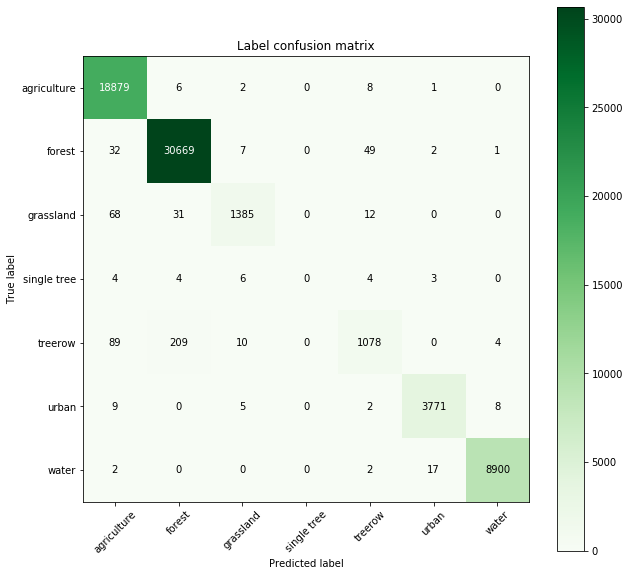

In [11]:
# smooth plot of the confusion matrix
label_mapping = {0: 'urban', 1: 'treerow', 2: 'forest', 3: 'single tree', 4: 'agriculture', 5: 'grassland', 6: 'water'}
skplt.metrics.plot_confusion_matrix(
    test_prediction_target1.replace(label_mapping), 
    pd.DataFrame(predictions1).replace(label_mapping),
    figsize = (10, 10),
    title = 'Label confusion matrix',
    x_tick_rotation = 45,
    cmap = 'Greens')

print(class_report_1)

We already have satifying results of the model but we can do better. Let's improve the model ! We can squash the 3 RGB layers into a unique grayscale layer :

In [12]:
final_dataset_df = pd.read_csv('final_dataset.csv')

# creation of the grayscale column
# the weights are respectively for : red, green, blue
rgb_weights = [0.2989, 0.5870, 0.1140]
rgb_df = pd.concat([final_dataset_df['blue'], final_dataset_df['green'], final_dataset_df['red']], axis = 1)
grayscale_df = rgb_df.dot(rgb_weights)
grayscale_df = grayscale_df.map(np.round).astype(int)
final_dataset_df['grayscale'] = grayscale_df

# split of the dataset
prediction_target = final_dataset_df['label']
X2 = final_dataset_df.drop(columns = ['label', 'blue', 'green', 'red'])
train_data2, test_data2, train_prediction_target2, test_prediction_target2 = train_test_split(X2, prediction_target, train_size = 0.8, random_state = 1)

# classifier training
model2 = RandomForestClassifier(random_state = 1)
model2.fit(train_data2, train_prediction_target2)
predictions2 = model2.predict(test_data2)

# evaluation of the classifier :
confusion_mtrx_2 = confusion_matrix(test_prediction_target2, predictions2)
class_report_2 = classification_report(test_prediction_target2, predictions2, zero_division = True)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3795
           1       0.98      0.93      0.95      1390
           2       1.00      1.00      1.00     30760
           3       1.00      0.10      0.17        21
           4       1.00      1.00      1.00     18896
           5       0.99      0.98      0.99      1496
           6       1.00      1.00      1.00      8921

    accuracy                           1.00     65279
   macro avg       0.99      0.86      0.87     65279
weighted avg       1.00      1.00      1.00     65279



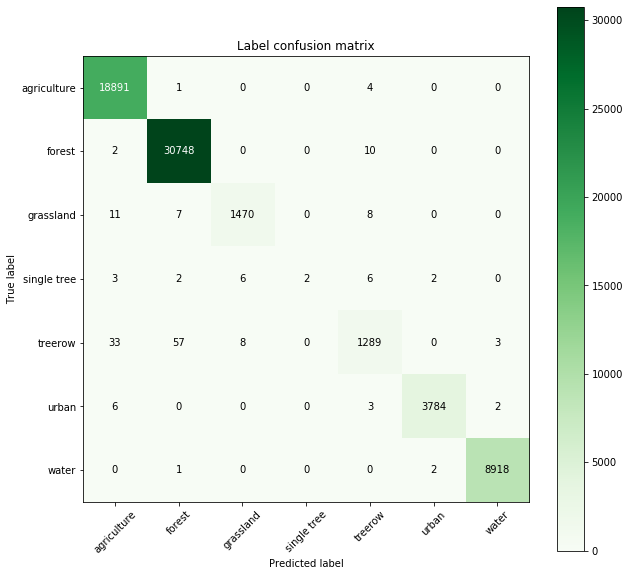

In [13]:
# smooth plot of the confusion matrix
label_mapping = {0: 'urban', 1: 'treerow', 2: 'forest', 3: 'single tree', 4: 'agriculture', 5: 'grassland', 6: 'water'}
skplt.metrics.plot_confusion_matrix(
    test_prediction_target2.replace(label_mapping), 
    pd.DataFrame(predictions2).replace(label_mapping),
    figsize = (10, 10),
    title = 'Label confusion matrix',
    x_tick_rotation = 45,
    cmap = 'Greens')

print(class_report_2)

That's better ! We improved by respectively **10 points** and **4 points** the f1-score of the treerow label and the grassland label.

## 3. Classifier limits

The Random Forest model is pretty bad at detecting single tree and tree row. An explanation to this behaviours is that the model should be able to **detect the nature of the direct neighbours of a pixel** in order to see if there are trees around or not. It would allow us to distinguish single tree and tree row from forest label.

Furthermore, one thing we could do with a little more time is to take advantage of the fact that **a hot body emits IR**. I also know that the heat above a field is higher than the average. With this hypothesis, we could then improve our model by focusing on the different IR wavelengths features to improve the agriculture and grassland recognition.

## Conclusion

I hope you had a nice reading !

Thibault Latrace

![Earth](resources/earth.jpg)